Get SentimentAnalysisData1.pickle: https://drive.google.com/drive/folders/1Q_DZT6ELtnieUQPfduH2JxIWypQYSEcV?usp=sharing

In [58]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import tensorflow as tf
import time

In [59]:
def reviewsByGrade(URL, reviews_by_grade):
    '''
        This function takes a URL from the section of robertchristgau.com that lists albums by their artist as input
        Then it scrapes the URL for its text before storing the text of the review along with its grade
    
        Input: a URL, 1 empty dictionary
        
        Output: nothing
        
        Modifies: appends review and grade to 1 dictionary (grade = key)
    '''
    
    text = BeautifulSoup(requests.get(URL).content, "html.parser").get_text().split("\n") # get just the text from the URL

    try:
        text = text[text.index('Follow @rxgau')+5:]

    except:
        print(URL)
    
    for i in text:
        if len(i) > 100: # we only want the reviews, and we only want reviews of sufficient length (since these are capsule reviews, some are only a few words, and we want to exclude these
            review, grade = i.rsplit(' ', 1)
            
            if grade == '***':
                grade = 'B+'
            if grade == '**':
                grade = 'B'
            if grade == '*':
                grade = 'B-'
            if grade == 'N':
                grade = 'B-'
            if grade == 'S':
                grade = 'C+'
            if grade == 'X':
                grade = 'C+'

            if grade in grades: # some reviews are ungraded - don't consider these
                if grade not in reviews_by_grade:
                    reviews_by_grade[grade] = [review]
                else:
                    reviews_by_grade[grade].append(review)

In [60]:
reviews_by_grade = {}

In [61]:
grades = {"A+":97,
          "A":93,
          "A-":90,
          "B+":87,
          "B":83,
          "B-":80,
          "C+":77,
          "C":73,
          "C-":70,
          "D+":67,
          "D":63,
          "D-":60,
          "E+":57,
          "E":53,
          "E-":50}

In [9]:
# let's time how long it takes to scrape all these URLs!
start_time = time.time()

# scrape our data
for i in range(1, 10000):
    reviewsByGrade("https://www.robertchristgau.com/get_artist.php?id=" + str(i), reviews_by_grade)
    
print()
print()
print(f"It took {time.time() - start_time} seconds to scrape all that data and create 1 dictionary to store it!")



It took 2253.829670906067 seconds to scrape all that data and create 1 dictionary to store it!


In [65]:
# save data
'''
with open('SentimentAnalysisData1.pickle', 'wb') as handle:
    pickle.dump(reviews_by_grade, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''
# load data
'''
with open('SentimentAnalysisData1.pickle', 'rb') as handle:
    reviews_by_grade = pickle.load(handle)
'''

"\nwith open('SentimentAnalysisData1.pickle', 'rb') as handle:\n    reviews_by_grade = pickle.load(handle)\n"

In [41]:
# convert reviews by grade into grades by review for dataframe purposes
grades_by_review = {}
for k, v in reviews_by_grade.items():
    for review in v:
        grades_by_review[review] = k
grades_df = pd.DataFrame.from_dict(grades_by_review,orient='index').reset_index().rename({'index': 'review', 0: 'grade'}, axis=1)  # new method

In [42]:
grades_df['random'] = np.random.normal(size = len(grades_df))

In [43]:
# let's see how many reviews we have per grade
my_sum = 0
for grade in sorted(list(reviews_by_grade.keys())):
    length = len(reviews_by_grade[grade])
    print(grade, length)
    my_sum += length

print(f'total: {my_sum}')

A 897
A+ 121
A- 3349
B 2102
B+ 2213
B- 1975
C 417
C+ 1693
C- 229
D 57
D+ 91
D- 19
E 13
E+ 4
E- 2
total: 13182


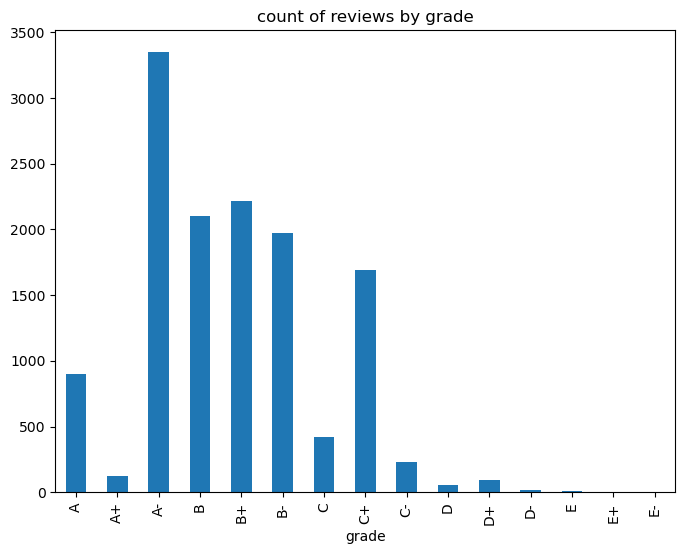

In [44]:
# actually, this might be a prettier way of doing it
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.title('count of reviews by grade')
grades_df.groupby('grade').review.count().plot.bar(ylim=0)
plt.show()

In [45]:
# I don't like the way the x-axis is sorted - let's group by num_grades, which will give us the same result, but in a way where it's easier to see the distribution of grades
# convert the grades to numerical so we can properly sort it, and so 
grades = {"A+":97,
          "A":93,
          "A-":90,
          "B+":87,
          "B":83,
          "B-":80,
          "C+":77,
          "C":73,
          "C-":70,
          "D+":67,
          "D":63,
          "D-":60,
          "E+":57,
          "E":53,
          "E-":50}
grades_df['num_grades'] = grades_df['grade'].map(grades)

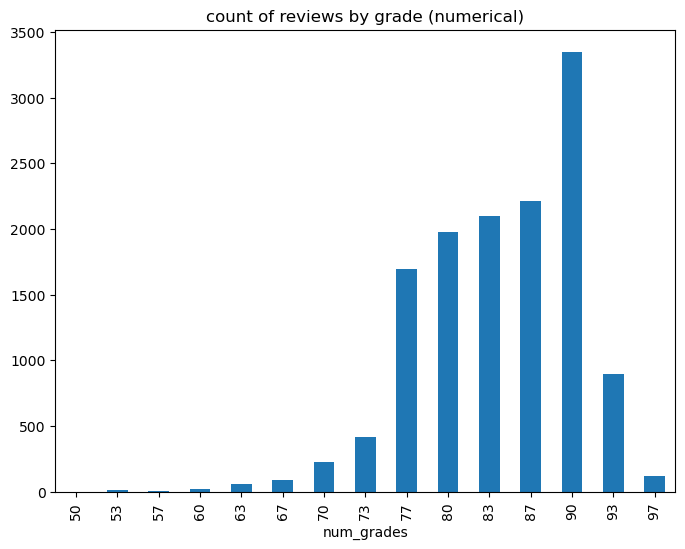

In [46]:
# plot with numerical grades
plt.figure(figsize=(8,6))
plt.title('count of reviews by grade (numerical)')
grades_df.groupby('num_grades').review.count().plot.bar(ylim=0)
plt.show()

I've been reading Christgau's reviews for a while. The reason I decided to embark on this analysis is because I often find myself completely unable to understand his reviews, let alone be able to infer from the review what the grade was. His references are frequent and esoteric, and the dense and complex vocabulary is employs can border on unreadable. Oftentimes I'll think I'm reading a C-range review only to get to the end and see it's in the A-range. I want to see if a computer could do any better than me.

What grade do you think Christgau gave to Moby's Play [1999]?

    "I doubt the hyperactive little imp sat down and "composed" here. There are no reports he even strove to unify à la DJ Shadow. And Endtroducing . . . is the reference point nevertheless. It's because Moby still loves song form that he elects to sample Alan Lomax field recordings rather than garage-sale instrumental and spoken-word LPs. But though the blues and gospel and more gospel testify not just for song but for body and spirit, they wouldn't shout anywhere near as loud and clear without the mastermind's ministrations--his grooves, his pacing, his textures, his harmonies, sometimes his tunes, and mostly his grooves, which honor not just dance music but the entire rock tradition it's part of. Although the futurist's dream of Blind Willie Johnson that opens this complete work was some kind of hit in England, here it'll be strictly for aesthetes. We've earned it."
    
Our rough hypothesis: A computer can't do any better than me at predicting the grade of the review given the text of the review.

In [47]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(grades_df['review'],grades_df['num_grades'],
                                   test_size=0.15, 
                                   shuffle=True)
# by default, AutoKeras use the last 20% of training data as validation data
# we keep our own test set to avoid overfitting

In [48]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [49]:
print(x_train.shape)
print(y_train.shape)
print(x_train[10])

(11204,)
(11204,)
But this much knottier 1965 session is the Rollins I keep going back to. The man is expansive here, too--casually interpolating rapt modal runs into his thoughtful thematic improvisations on the 16-minute title tour de force, for instance--but the context is more angular, with continual commentary by Billy Higgins (who shares the drumming with Mickey Roker) that erases the memory of Tony Williams's work on Don't Stop the Carnival. Also knotty is the question of who owns this music--Rollins has claimed in court that ABC had no right to release it.


In [20]:
# https://autokeras.com/tutorial/text_regression/
import autokeras
from autokeras import TextRegressor

In [21]:
text_reg = TextRegressor(overwrite=True, max_trials=10)
text_reg.fit(x_train, y_train, epochs=5)

Trial 10 Complete [11h 40m 10s]
val_loss: 38.62653732299805

Best val_loss So Far: 29.36252784729004
Total elapsed time: 11h 47m 58s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
351/351 [==============================] - 10s 28ms/step - loss: 352.3302 - mean_squared_error: 352.3302
Epoch 2/5
351/351 [==============================] - 10s 28ms/step - loss: 24.3342 - mean_squared_error: 24.3342
Epoch 3/5
351/351 [==============================] - 10s 28ms/step - loss: 21.4666 - mean_squared_error: 21.4666
Epoch 4/5
351/351 [==============================] - 10s 29ms/step - loss: 19.3385 - mean_squared_error: 19.3385
Epoch 5/5
351/351 [==============================] - 10s 29ms/step - loss: 16.6878 - mean_squared_error: 16.6878


INFO:tensorflow:Assets written to: ./text_regressor/best_model/assets


INFO:tensorflow:Assets written to: ./text_regressor/best_model/assets


In [22]:
y_pred = text_reg.predict(x_test)

62/62 [==============================] - 1s 8ms/step


In [23]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

In [26]:
r2

-0.041925824413770574

It doesn't look like there's a pattern...but let's take the average of this and 3 more regressions just to make sure our results didn't come from some weird slicing of the data

Each time we run the below loop, we reassign the train/val/test sets

In [24]:
r2scores = [r2]
for i in range(3):
    x_train, x_test, y_train, y_test = train_test_split(grades_df['review'],grades_df['num_grades'],
                                   test_size=0.15, 
                                   shuffle=True)
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    text_reg = TextRegressor(overwrite=True, max_trials=10)
    text_reg.fit(x_train, y_train, epochs=5)
    r2scores.append(r2_score(y_test, text_reg.predict(x_test)))

Trial 10 Complete [00h 00m 10s]
val_loss: 36.57345199584961

Best val_loss So Far: 36.08848571777344
Total elapsed time: 00h 01m 29s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/5
351/351 [==============================] - 2s 6ms/step - loss: 447.4321 - mean_squared_error: 447.4321
Epoch 2/5
351/351 [==============================] - 2s 6ms/step - loss: 28.5334 - mean_squared_error: 28.5334
Epoch 3/5
351/351 [==============================] - 2s 6ms/step - loss: 24.4540 - mean_squared_error: 24.4540
Epoch 4/5
351/351 [==============================] - 2s 6ms/step - loss: 22.7526 - mean_squared_error: 22.7526
Epoch 5/5
351/351 [==============================] - 2s 6ms/step - loss: 20.2296 - mean_squared_error: 20.2296


INFO:tensorflow:Assets written to: ./text_regressor/best_model/assets


INFO:tensorflow:Assets written to: ./text_regressor/best_model/assets


62/62 [==============================] - 0s 2ms/step


In [39]:
print(sum(r2scores)/len(r2scores))

-0.15083317490656


The average R^2 score between 4 separate runs of the auto-text regression is negative and close to 0, meaning there is no statistically significant positive relationship between the predicted grades and the real grades. In other words, autokeras' TextRegressor could not predict the grade of a review from the text of a review with any accuracy. 

Does this mean there is certainly no way to predict his grade from the review? No, but it does give evidence to my suspicion that doing so is a difficult task both for a human and a robot. Perhaps a manually trained neural network would have more success than our AutoML.

And Moby's Play received an A+ - only one of ~125 Christgau has given in his reviewing career - though I certainly wouldn't have guessed that from the capsule review.